## Общее описание:
Есть данные о такси-компании (uber), которая хочет изучить отток водителей и посмотреть, какие есть различия между водителями, которые покидают сервис, и которые остаются. Нужно сформулировать и протестировать гипотезы, выделить группы водителей, которые наиболее подвержены "оттоку". На основе результатов сделать выводы о том, что можно улучшить в сервисе, чтобы в дальнейшем внести изменения (и после – провести A/B тест и выяснить, стало ли лучше).

### План

1. **Сначала сделаем небольшой препроцессинг:**
    - Посмотрим на данные
2. **Далее сформулируем гипотезы, исходя из общей задачи:**
    - Сформулируем предположения, которые будем тестировать
    - Создадим лейбл churn/not_churn
    - Построим графики
    - **Поинт:** только по графикам выводы делать – bad practice, хорошо подкреплять стат. тестами (и стат. тесты есть не только в A/B)
3. **Тестируем гипотезы:**
     - Выбираем гипотезу
     - Выбираем подходящий тест
     - Тестируем
4. **Подводим итоги:**
    - Сформулировать выводы и суммаризировать всё что было
    - Какие действия нужно предпринять разработчикам/бизнесу, чтобы стало лучше? Как можно будет позже провести A/B тестирование? (починить android приложение, возможно таргетить и мотивировать не очень активных водителей, улучшить программу лояльности и бонусов для водителей и тд и тп)



Данные:

- `city` – город
- `phone` – основное устройство, которое использует водитель 
- `signup_date` – дата регистрации аккаунта (`YYYYMMDD`)
- `last_trip_date` – дата последней поездки (`YYYYMMDD`)
- `avg_dist` – среднее расстояние (в милях) за поездку в первые 30 дней после регистрации
- `avg_rating_by_driver` – средняя оценка поездок водителем 
- `avg_rating_of_driver` – средняя оценка поездок водителя
- `surge_pct` – процент поездок, совершенных с множителем > 1 
- `avg_surge` – средний множитель всплеска за все поездки этого водителя
- `trips_in_first_30_days` – количество поездок, которые совершил водитель в первые 30 дней после регистрации
- `luxury_car_user` – TRUE, если пользователь в первые 30 дней использовал премиум-автомобиль
- `weekday_pct` – процент поездок пользователя, совершенных в будние дни


In [147]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import pingouin as pg
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(12,6)}, style="whitegrid")

In [148]:
df = pd.read_csv('churn.csv')

In [149]:
df.head()

avg_dist  avg_rating_by_driver  avg_rating_of_driver  avg_surge  \
0      3.67                   5.0                   4.7       1.10   
1      8.26                   5.0                   5.0       1.00   
2      0.77                   5.0                   4.3       1.00   
3      2.36                   4.9                   4.6       1.14   
4      3.13                   4.9                   4.4       1.19   

             city last_trip_date    phone signup_date  surge_pct  \
0  King's Landing     2014-06-17   iPhone  2014-01-25       15.4   
1         Astapor     2014-05-05  Android  2014-01-29        0.0   
2         Astapor     2014-01-07   iPhone  2014-01-06        0.0   
3  King's Landing     2014-06-29   iPhone  2014-01-10       20.0   
4      Winterfell     2014-03-15  Android  2014-01-27       11.8   

   trips_in_first_30_days  luxury_car_user  weekday_pct  
0                       4             True         46.2  
1                       0            False         50.0  
2                       3            False        100.0  
3                       9             True         80.0  
4                      14            False         82.4

In [150]:
df.shape

(50000, 12)

In [151]:
df.isna().sum()

avg_dist                     0
avg_rating_by_driver       201
avg_rating_of_driver      8122
avg_surge                    0
city                         0
last_trip_date               0
phone                      396
signup_date                  0
surge_pct                    0
trips_in_first_30_days       0
luxury_car_user              0
weekday_pct                  0
dtype: int64

In [152]:
df.nunique()

avg_dist                  2908
avg_rating_by_driver        27
avg_rating_of_driver        37
avg_surge                  115
city                         3
last_trip_date             182
phone                        2
signup_date                 31
surge_pct                  367
trips_in_first_30_days      59
luxury_car_user              2
weekday_pct                666
dtype: int64

In [153]:
df.dtypes

avg_dist                  float64
avg_rating_by_driver      float64
avg_rating_of_driver      float64
avg_surge                 float64
city                       object
last_trip_date             object
phone                      object
signup_date                object
surge_pct                 float64
trips_in_first_30_days      int64
luxury_car_user              bool
weekday_pct               float64
dtype: object

Изменяем тип для дат:


In [154]:
df.last_trip_date = pd.to_datetime(df.last_trip_date)
df.signup_date = pd.to_datetime(df.signup_date)

In [155]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   avg_dist                50000 non-null  float64       
 1   avg_rating_by_driver    49799 non-null  float64       
 2   avg_rating_of_driver    41878 non-null  float64       
 3   avg_surge               50000 non-null  float64       
 4   city                    50000 non-null  object        
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   signup_date             50000 non-null  datetime64[ns]
 8   surge_pct               50000 non-null  float64       
 9   trips_in_first_30_days  50000 non-null  int64         
 10  luxury_car_user         50000 non-null  bool          
 11  weekday_pct             50000 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

In [156]:
df.describe()

avg_dist  avg_rating_by_driver  avg_rating_of_driver     avg_surge  \
count  50000.000000          49799.000000          41878.000000  50000.000000   
mean       5.796827              4.778158              4.601559      1.074764   
std        5.707357              0.446652              0.617338      0.222336   
min        0.000000              1.000000              1.000000      1.000000   
25%        2.420000              4.700000              4.300000      1.000000   
50%        3.880000              5.000000              4.900000      1.000000   
75%        6.940000              5.000000              5.000000      1.050000   
max      160.960000              5.000000              5.000000      8.000000   

          surge_pct  trips_in_first_30_days   weekday_pct  
count  50000.000000            50000.000000  50000.000000  
mean       8.849536                2.278200     60.926084  
std       19.958811                3.792684     37.081503  
min        0.000000                0.000000      0.000000  
25%        0.000000                0.000000     33.300000  
50%        0.000000                1.000000     66.700000  
75%        8.600000                3.000000    100.000000  
max      100.000000              125.000000    100.000000

In [157]:
df.describe(include='object')

city   phone
count        50000   49604
unique           3       2
top     Winterfell  iPhone
freq         23336   34582

In [158]:
df.describe(include='datetime')

C:\Users\Администратор\AppData\Local\Temp\ipykernel_9728\2102073941.py:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.

C:\Users\Администратор\AppData\Local\Temp\ipykernel_9728\2102073941.py:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



last_trip_date          signup_date
count                 50000                50000
unique                  182                   31
top     2014-06-29 00:00:00  2014-01-18 00:00:00
freq                   2036                 2948
first   2014-01-01 00:00:00  2014-01-01 00:00:00
last    2014-07-01 00:00:00  2014-01-31 00:00:00

In [159]:
df.head()

avg_dist  avg_rating_by_driver  avg_rating_of_driver  avg_surge  \
0      3.67                   5.0                   4.7       1.10   
1      8.26                   5.0                   5.0       1.00   
2      0.77                   5.0                   4.3       1.00   
3      2.36                   4.9                   4.6       1.14   
4      3.13                   4.9                   4.4       1.19   

             city last_trip_date    phone signup_date  surge_pct  \
0  King's Landing     2014-06-17   iPhone  2014-01-25       15.4   
1         Astapor     2014-05-05  Android  2014-01-29        0.0   
2         Astapor     2014-01-07   iPhone  2014-01-06        0.0   
3  King's Landing     2014-06-29   iPhone  2014-01-10       20.0   
4      Winterfell     2014-03-15  Android  2014-01-27       11.8   

   trips_in_first_30_days  luxury_car_user  weekday_pct  
0                       4             True         46.2  
1                       0            False         50.0  
2                       3            False        100.0  
3                       9             True         80.0  
4                      14            False         82.4

## 2: графики, гипотезы и тесты

Создаем лейбл churn – пользователь ушел, **если не был активен последние 30 дней** (но можно попробовать и другие значения)

In [160]:
df.last_trip_date.max()

Timestamp('2014-07-01 00:00:00')

In [161]:
df['days_since_last_trip'] = df.last_trip_date.max() - df.last_trip_date

In [162]:
df['days_since_last_trip']

0        14 days
1        57 days
2       175 days
3         2 days
4       108 days
          ...   
49995    26 days
49996   157 days
49997    40 days
49998   167 days
49999    72 days
Name: days_since_last_trip, Length: 50000, dtype: timedelta64[ns]

Преобразуем в int:

In [163]:
df['days_since_last_trip'] = df['days_since_last_trip'].dt.days
df['days_since_last_trip']

0         14
1         57
2        175
3          2
4        108
        ... 
49995     26
49996    157
49997     40
49998    167
49999     72
Name: days_since_last_trip, Length: 50000, dtype: int64

In [164]:
df['churn'] = df.days_since_last_trip.apply(lambda x: 'churn' if x > 30 else 'not_churn')
df[['days_since_last_trip', 'churn']]

days_since_last_trip      churn
0                        14  not_churn
1                        57      churn
2                       175      churn
3                         2  not_churn
4                       108      churn
...                     ...        ...
49995                    26  not_churn
49996                   157      churn
49997                    40      churn
49998                   167      churn
49999                    72      churn

[50000 rows x 2 columns]

### churn

Видим, что очень много пользователей не использовали сервис в последнем месяце. Нужно разобраться, какие факторы могут влиять на отток водителей

In [165]:
df.churn.value_counts(normalize=True).mul(100)

churn        62.392
not_churn    37.608
Name: churn, dtype: float64

In [166]:
fig = px.histogram(df, x='churn')
fig.show()

Еще лучше – отразим на графике нормализованные значения (сравниваем не сырые числа):

In [167]:
fig = px.histogram(df, x='churn', histnorm='probability density')
fig.show()

### churn & phone

Предположим, что проблема может быть среди юзеров на конкретной платформе:

In [168]:
pd.crosstab(df.churn, df.phone)

phone      Android  iPhone
churn                     
churn        11876   19057
not_churn     3146   15525

In [169]:
fig = px.histogram(df[['churn', 'phone']].dropna(), x='churn', 
                   color='phone')
fig.show()

Делать вывод только по графику – не очень хорошо, поэтому проверим нашу гипотезу с помощью статистического теста.

Есть две категориальные переменные → нужен хи-квадрат

- $H_0$: взаимосвязи между переменными нет 
- $H_1$: взаимосвязь есть

In [170]:
from scipy.stats import chi2_contingency, chi2 

In [171]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df.churn, df.phone))

In [172]:
stat, p, dof

(2558.394212267425, 0.0, 1)

Интерпретируем результат:

In [173]:
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Отклоняем H0


**2.** Проверьте, есть ли различия в размерах оттока клиентов в разных городах (churn, city)

In [174]:
pd.crosstab(df.churn, df.city)

city       Astapor  King's Landing  Winterfell
churn                                         
churn        12306            3767       15123
not_churn     4228            6363        8213

In [175]:
fig = px.histogram(df[['churn', 'city']].dropna(), x='city', 
                   color='churn')
fig.show()

In [176]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df.churn, df.city))
stat, p, dof

(3821.5510225559633, 0.0, 2)

In [177]:
prob = 0.95
alpha = 1.0 - prob
print('Отклоняем H0') if p <= alpha else print('Не отклоняем H0')

Отклоняем H0


**2.** Есть ли разница в активности в первые 30 дней с момента регистрации между водителями из разных городов? (city, trips_in_first_30_days)

In [178]:
df.head()

avg_dist  avg_rating_by_driver  avg_rating_of_driver  avg_surge  \
0      3.67                   5.0                   4.7       1.10   
1      8.26                   5.0                   5.0       1.00   
2      0.77                   5.0                   4.3       1.00   
3      2.36                   4.9                   4.6       1.14   
4      3.13                   4.9                   4.4       1.19   

             city last_trip_date    phone signup_date  surge_pct  \
0  King's Landing     2014-06-17   iPhone  2014-01-25       15.4   
1         Astapor     2014-05-05  Android  2014-01-29        0.0   
2         Astapor     2014-01-07   iPhone  2014-01-06        0.0   
3  King's Landing     2014-06-29   iPhone  2014-01-10       20.0   
4      Winterfell     2014-03-15  Android  2014-01-27       11.8   

   trips_in_first_30_days  luxury_car_user  weekday_pct  days_since_last_trip  \
0                       4             True         46.2                    14   
1                       0            False         50.0                    57   
2                       3            False        100.0                   175   
3                       9             True         80.0                     2   
4                      14            False         82.4                   108   

       churn  
0  not_churn  
1      churn  
2      churn  
3  not_churn  
4      churn

In [179]:
df.groupby('city')['trips_in_first_30_days'].describe()

count      mean       std  min  25%  50%  75%    max
city                                                                  
Astapor         16534.0  1.948651  3.333600  0.0  0.0  1.0  2.0   73.0
King's Landing  10130.0  2.463672  4.326140  0.0  0.0  1.0  3.0  125.0
Winterfell      23336.0  2.431179  3.835147  0.0  0.0  1.0  3.0   71.0

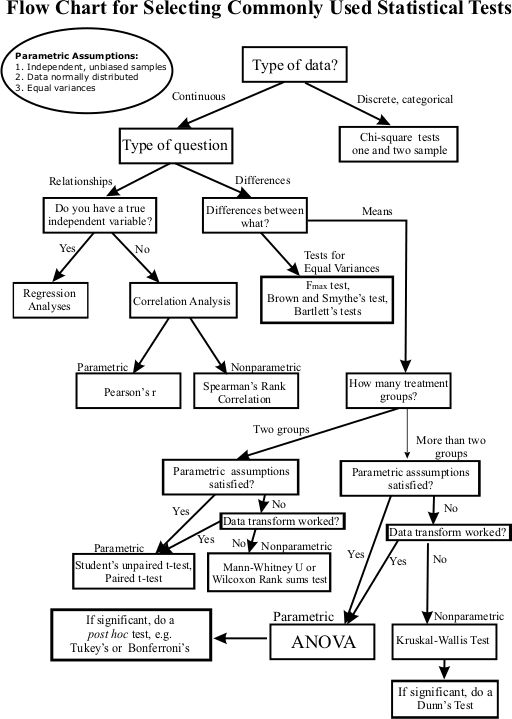

Мы ищем отличие в средних -> группы 3 -> после проверки на нормальность приходим к выводу что параметрические требования не удовлетворены (ниже тест на нормальность), как и гомогенность дисперсий (Левена) -> поэтому переходим к тесту Крускела.

In [180]:
A = df[df.city == 'Astapor']['trips_in_first_30_days']
B = df[df.city == 'King\'s Landing']['trips_in_first_30_days']
C = df[df.city == 'Winterfell']['trips_in_first_30_days']

In [181]:
print(ss.normaltest(A))
print(ss.normaltest(B))
print(ss.normaltest(C))

NormaltestResult(statistic=18186.739337583633, pvalue=0.0)
NormaltestResult(statistic=12011.013892107436, pvalue=0.0)
NormaltestResult(statistic=21390.545654544698, pvalue=0.0)


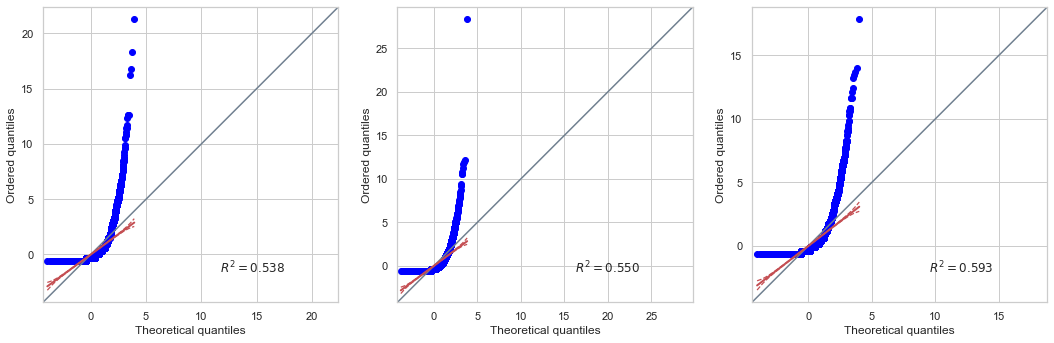

In [182]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
ax1 = pg.qqplot(A, ax=ax1)
ax2 = pg.qqplot(B, ax=ax2)
ax3 = pg.qqplot(C, ax=ax3)

In [183]:
ss.levene(A, B, C)

LeveneResult(statistic=98.09872813049195, pvalue=3.0174362755471005e-43)

In [184]:
# Kruskal-Wallis тест

p = ss.kruskal(A, B, C)[1]

In [185]:
prob = 0.95
alpha = 1.0 - prob
print('Отклоняем H0') if p <= alpha else print('Не отклоняем H0')

Отклоняем H0


**4.** Может ли отток быть связан с активностью в первые 30 дней после регистрации? (churn, trips_in_first_30_days)

In [186]:
df.groupby('churn')['trips_in_first_30_days'].describe()

count      mean       std  min  25%  50%  75%    max
churn                                                            
churn      31196.0  1.658482  2.654222  0.0  0.0  1.0  2.0   73.0
not_churn  18804.0  3.306318  4.986743  0.0  0.0  2.0  4.0  125.0

In [187]:
A = df[df.churn == 'churn']['trips_in_first_30_days']
B = df[df.churn == 'not_churn']['trips_in_first_30_days']

<AxesSubplot:xlabel='trips_in_first_30_days', ylabel='churn'>

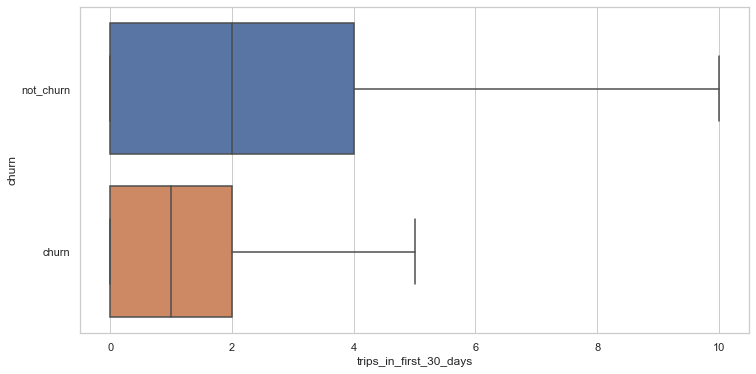

In [188]:
sns.boxplot(data=df, x=df.trips_in_first_30_days, y=df.churn, showfliers = False) 

Имеем две группы с не нормальным распределением. Параметрические критерии не удовлетворены. согласно схемы выше, используем критерий Манна Уитни

In [189]:
p = ss.mannwhitneyu(A, B)[1]

In [190]:
prob = 0.95
alpha = 1.0 - prob
print('Отклоняем H0') if p <= alpha else print('Не отклоняем H0')

Отклоняем H0


Распределение переменной trips_in_first_30_days не является нормальным, поэтому для проверки гипотезы я использую U-критерий Манна-Уитни. Результат оказался статистически значим. Значит, значимые различия есть, ушедшие пользователи были менее активны